In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

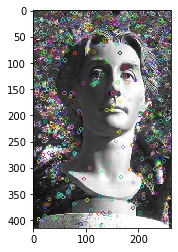

In [2]:
img1 = cv2.imread("./1.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# detect kepoints and their descriptor for 'img1' using SIFT
sift = cv2.SIFT_create()
kp1, dst1 = sift.detectAndCompute(img1, None)
# visualiziation
img_1 = cv2.drawKeypoints(img1, kp1, img1)
plt.imshow(img_1)

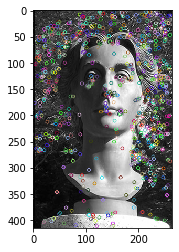

In [3]:
img2 = cv2.imread("./2.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# detect kepoints and their descriptor for 'img2' using SIFT
sift = cv2.SIFT_create()
kp2, dst2 = sift.detectAndCompute(img2, None)
# visualiziation
img_2 = cv2.drawKeypoints(img2, kp2, img2)
plt.imshow(img_2)

In [4]:
# Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(dst1, dst2, k=2)

# Keep good matches: calculate distinctive image features
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [5]:
# ------------------------------------------------------------
# STEREO RECTIFICATION

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

In [6]:
# Stereo rectification (uncalibrated variant)
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1))

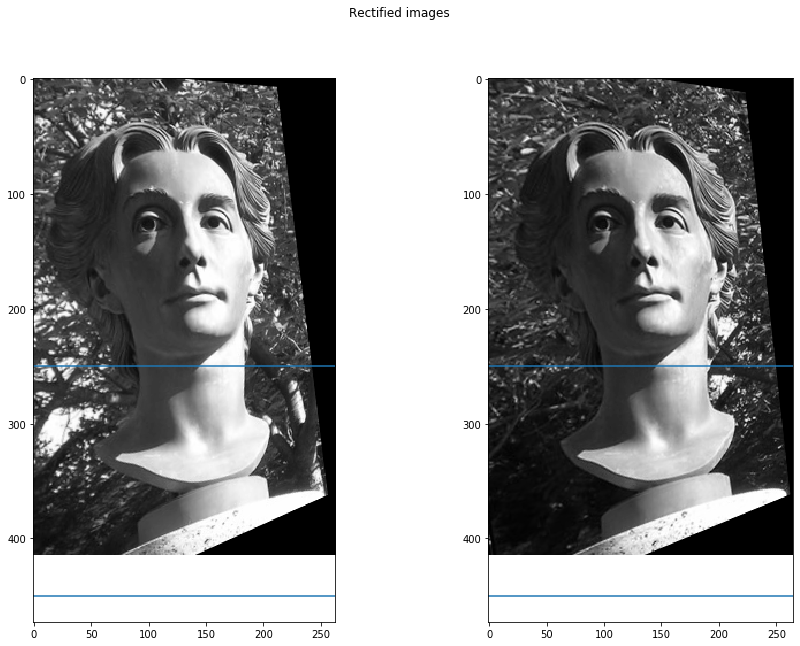

In [7]:
# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))
# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()